In [68]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random

## Brief Outline

The notebook will proceed in the following manner:

1. Brief description of Data
2. Defining QLSTM with DRC and using it to perform stock price prediction


## 1. Data

First, we read in the data, dropping the index and the date.

In [69]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])
df=df[:100]

We identify the dependent and independent variables:

In [70]:
target = "Close"

In [71]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data Processing

To process the data, we first define few terms

In [72]:
sequence_length = window= 14 # Number of time steps that will be inputted into LSTM network and Number of Predicting days 
batch_size=16 # Number of training instances in the batch
torch.manual_seed(101)
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [73]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [74]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,FT9,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume
0,0.012995,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,0.029243,0.012995,1.411000,-3.152930,...,1.854712,2.592148,1.601011,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,0.430117
1,-0.696678,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-0.682508,-0.696678,0.828470,-3.152930,...,1.812925,2.161558,2.181198,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,-0.143354
2,-1.757546,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-1.778908,-1.757546,0.828470,-3.152930,...,1.771162,2.161558,2.181198,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,-0.276309
3,-1.453961,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-1.461052,-1.453961,0.994908,-3.152930,...,1.729429,1.730969,2.134977,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,0.319218
4,-0.547686,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-0.531676,-0.547686,1.859786,-3.152930,...,1.687730,0.869790,1.457485,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,-0.090411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.378009,0.112913,0.564471,0.549079,0.801435,0.534538,1.352645,1.378009,0.510457,0.451796,...,-1.406991,-1.713745,-0.572560,1.153489,0.379173,1.258185,0.459923,0.549079,0.995527,1.970389
96,1.233497,0.009253,0.576177,0.554918,0.565190,0.534991,1.215263,1.233497,0.266745,0.452333,...,-1.428371,-1.713745,-0.778119,1.061804,0.130678,1.300059,0.464038,0.554918,0.996330,1.729874
97,1.350002,-0.159000,0.592577,0.561766,0.669216,0.533074,1.326069,1.350002,0.266745,0.455193,...,-1.449404,-1.713745,-0.778119,1.018244,0.009018,1.322279,0.469485,0.561766,0.997406,-0.715588
98,1.555007,-0.243888,0.603879,0.568193,0.897878,0.535024,1.520061,1.555007,0.590703,0.461792,...,-1.470087,-1.713745,-0.476471,1.048502,0.030010,1.347889,0.469107,0.568193,0.998336,1.402693


In [75]:
def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(len(dataset)-lookback-window):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

X_ts, y_ts = create_dataset(
    df,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_ts.shape, y_ts.shape)

torch.Size([72, 14, 23]) torch.Size([72, 14])


In [76]:
indices = torch.randperm(X_ts.size()[0])
X_ts=X_ts[indices]
y_ts=y_ts[indices]

In [77]:
print(X_ts.shape, y_ts.shape)
X_ts=torch.FloatTensor(np.array(X_ts))
y_ts=torch.FloatTensor(np.array(y_ts))
print(X_ts.shape, y_ts.shape)

torch.Size([72, 14, 23]) torch.Size([72, 14])
torch.Size([72, 14, 23]) torch.Size([72, 14])


In [78]:
# Train test split
n=X_ts.shape[0] # get first dimension
size=int(n*0.9)
X_train_ts=X_ts[:size]
y_train_ts=y_ts[:size]
X_test_ts=X_ts[size:]
y_test_ts=y_ts[size:]
print('Shape of train is',X_train_ts.shape,'and',y_train_ts.shape)
print('Shape os test is',X_test_ts.shape,'and',y_test_ts.shape)

Shape of train is torch.Size([64, 14, 23]) and torch.Size([64, 14])
Shape os test is torch.Size([8, 14, 23]) and torch.Size([8, 14])


In [79]:
train_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=True, batch_size=batch_size)

In [80]:
# The unknown data
X_check=(df[features].values)[len(df)-window-sequence_length+1:len(df)- window+1]
y_check=(df[target].values)[len(df)-window:len(df)]
torch.FloatTensor([X_check]).shape

torch.Size([1, 14, 23])

In [81]:
# for X, y in train_loader:
#     print(X)
#     print(y)

## Running DRC

In [82]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [83]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=2,
                n_inp_size=18, # Decide the number of input to quantum model
                n_qlayers=1,
                n_vrotations=3,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size 
        self.hidden_size = hidden_size
        self.n_inp_size=n_inp_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget, shots=None)
        self.dev_input = qml.device(self.backend, wires=self.wires_input, shots=None)
        self.dev_update = qml.device(self.backend, wires=self.wires_update, shots=None)
        self.dev_output = qml.device(self.backend, wires=self.wires_output, shots=None)
            
        def VQC(inputs, weights, wires_type): # inputs, weights, self.wires_update
            inputs_ = [torch.arctan(feature) for feature in inputs]               
            for p1,p2,p3,p4,p5,p6 in zip(weights[:4],weights[4:8],weights[8:12],weights[12:16],weights[16:20],weights[20:]):
                qml.Rot(*inputs_[:3], wires=wires_type[0])
                qml.Rot(*inputs_[3:6], wires=wires_type[1])
                qml.Rot(*inputs_[6:9], wires=wires_type[2])
                qml.Rot(*inputs_[9:12], wires=wires_type[3])
                qml.Rot(*inputs_[12:15], wires=wires_type[4])
                qml.Rot(*inputs_[15:], wires=wires_type[5])
#                 qml.CNOT(wires=[wires_type[0], wires_type[1]])
#                 qml.CNOT(wires=[wires_type[1], wires_type[2]])
#                 qml.CNOT(wires=[wires_type[2], wires_type[3]])
#                 qml.CNOT(wires=[wires_type[3], wires_type[4]])
#                 qml.CNOT(wires=[wires_type[4], wires_type[5]])
#                 qml.CNOT(wires=[wires_type[5], wires_type[0]])
                qml.Rot(*p1, wires=wires_type[0])
                qml.Rot(*p2, wires=wires_type[1])
                qml.Rot(*p3, wires=wires_type[2])
                qml.Rot(*p4, wires=wires_type[3])
                qml.Rot(*p5, wires=wires_type[4])
                qml.Rot(*p6, wires=wires_type[5])
                qml.CNOT(wires=[wires_type[0], wires_type[1]])
                qml.CNOT(wires=[wires_type[1], wires_type[2]])
                qml.CNOT(wires=[wires_type[2], wires_type[3]]) 
                qml.CNOT(wires=[wires_type[3], wires_type[4]])
                qml.CNOT(wires=[wires_type[4], wires_type[5]])
                qml.CNOT(wires=[wires_type[5], wires_type[0]])
                
        def _circuit_forget(inputs, weights):
            VQC(inputs, weights, self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch", diff_method='backprop')

        def _circuit_input(inputs, weights):
            VQC(inputs, weights, self.wires_input)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch", diff_method='backprop')

        def _circuit_update(inputs, weights):
            VQC(inputs, weights, self.wires_update)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch", diff_method='backprop')

        def _circuit_output(inputs, weights):
            VQC(inputs, weights, self.wires_output)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch", diff_method='backprop')

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations)}
        print(f"weight_shapes = (n_qlayers, n_vrotations) = ({self.n_qlayers}, {self.n_vrotations})")

        self.clayer_in = torch.nn.Linear(self.concat_size, self.n_inp_size)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [84]:
class QShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=1, n_qlayers=24): # n_qlayers decide the weights
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(out_)  # First dim of Hn is num_layers, which is set to 1 above.

        return torch.squeeze(out)

In [85]:
learning_rate = 0.05
num_hidden_units = 100

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=6)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations) = (24, 3)


In [86]:
quantum_loss_train = []
quantum_loss_test = []
num_epoch=1
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    end = time.time()
    test_loss = test_model(test_loader, Qmodel, loss_function)
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.7099518030881882
Test loss: 0.6027649641036987
Execution time 475.48799228668213


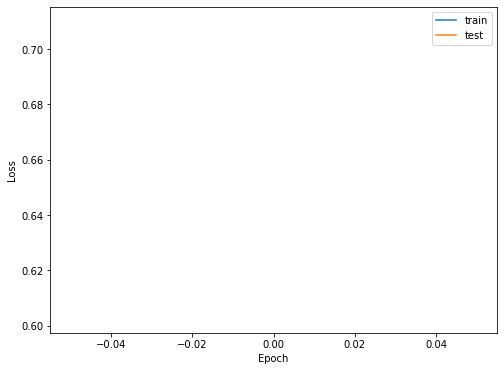

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), quantum_loss_train, label='train')
plt.plot(range(num_epoch), quantum_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [88]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [89]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=False, batch_size=batch_size)
y_train_pred_qlstm=predict(train_eval_loader, Qmodel)
y_train_qlstm=[]
for X, y in train_eval_loader:
    y_train_qlstm.append(y)
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=False, batch_size=batch_size)
y_test_pred_qlstm=predict(test_eval_loader, Qmodel)
y_test_qlstm=[]
for X, y in test_eval_loader:
    y_test_qlstm.append(y)

In [90]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [91]:
mae_train_qlstm, rmse_train_qlstm= cal_metrics(y_train_qlstm,y_train_pred_qlstm)
print('MAE train error is',mae_train_qlstm)
print('RMSE train error is',rmse_train_qlstm)
mae_test_qlstm, rmse_test_qlstm= cal_metrics(y_test_qlstm,y_test_pred_qlstm)
print('MAE test error is',mae_test_qlstm)
print('RMSE test error is',rmse_test_qlstm)

MAE train error is 98.7656307220459
RMSE train error is 139.658353805542
MAE test error is 93.40594482421875
RMSE test error is 138.60934448242188


In [92]:
y_check_pred_qlstm = Qmodel(torch.FloatTensor([X_check]))
y_check_pred_qlstm = y_check_pred_qlstm.detach().numpy()

mae_check_qlstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_qlstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_qlstm)
rmse_check_qlstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_qlstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_qlstm)

MAE check error  :  124.08401227678567
RMSE check error :  128.54655779275078


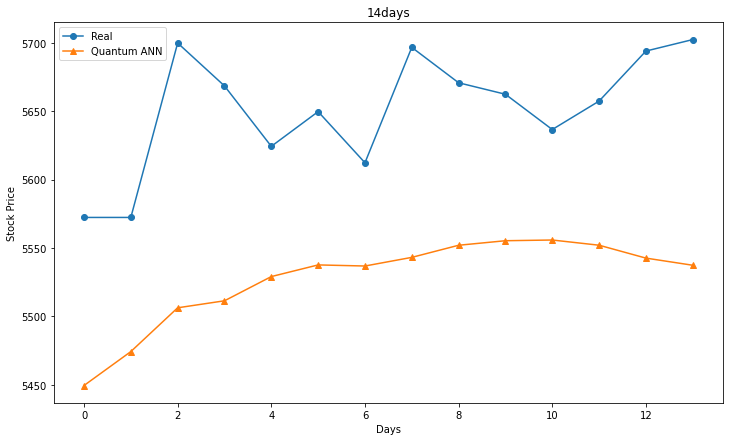

In [93]:
plt.figure(figsize=(12, 7))
plt.plot(y_check* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_qlstm* target_stdev + target_mean, label = "Quantum ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title(str(window)+'days')
plt.legend()
plt.show()

In [94]:
save_data=[y_check* target_stdev + target_mean,
          y_check_pred_qlstm* target_stdev + target_mean]

In [95]:
import csv 
# name of csv file   
filename = "LSTM_DRC_result_code.csv"
      
# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)     
          
    # writing the data rows   
    csvwriter.writerows(save_data)